In [1]:
import numpy as np
from numpy import interp

import pandas as pd
import matplotlib.pyplot as plt 
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier


In [2]:
from pprint import pprint
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc


### Generating data frames

In [3]:
comp = pd.read_csv('companies.csv')
comp = comp[comp.lat.notna() & comp.stage.notna() 
     & comp.name.notna() & comp["size_numeric"].notna()]
comp['market'] = comp['market'].apply(lambda row: str(row).replace(" ", "_"))


In [4]:
comp.columns

Index(['Unnamed: 0', 'joined', 'kind', 'link', 'location', 'market', 'name',
       'pitch', 'raised', 'size', 'stage', 'website', 'years', 'annual_raised',
       'annual_mil', 'raised_2mil', 'raised_12mil', 'lat', 'long',
       'size_numeric'],
      dtype='object')

### Onehot Encoding

In [5]:
comp_y = comp['annual_mil']

In [6]:
seed = comp[(comp["stage"]=="Seed")]
seed_y = seed['raised_2mil']

In [7]:
seed.shape

(1882, 20)

In [8]:
seriesA = comp[(comp["stage"]=="Series A")]
seriesA_y = seriesA['raised_12mil']

In [9]:
def one_hot(dataframe, nominal):
    gen_onehot_features = pd.get_dummies(dataframe[nominal])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop([nominal],axis=1,inplace=True)
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

In [10]:
def one_hot_market(dataframe):
    gen_onehot_features = pd.get_dummies(dataframe['market'])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop(['market'],axis=1,inplace=True)
#     print(result.columns[(result == 0).sum() > 0.995*result.shape[0]])
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

def one_hot_location(dataframe):
    gen_onehot_features = pd.get_dummies(dataframe['location'])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop(['location'],axis=1,inplace=True)
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

In [11]:
seriesA['size'].value_counts()

11-50        283
51-200       136
1-10          91
201-500       15
501-1000       3
1001-5000      1
Name: size, dtype: int64

### Data for modelling

In [12]:
seed_x =one_hot(one_hot(seed[['location','size_numeric','years','market']],"location"),"market")
# seed_x =one_hot(one_hot(one_hot(seed[['location','size','years','market']],"location"),"market"),"size")


In [13]:
seed_x

,size_numeric,years,Amsterdam,Atlanta,Austin,Bengaluru,Berlin,Boulder,Buenos Aires Province,Cambridge,...,Productivity_Software,Retail_Technology,SaaS,Small_and_Medium_Businesses,Social_Media,Social_Media_Platforms,Technology,Training,Video_Streaming,nan
1,5.0,7.627397,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,25.0,5.375342,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,25.0,6.290411,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,25.0,3.871233,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,5.0,7.290411,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4252,5.0,4.627397,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4254,5.0,5.871233,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4255,25.0,7.208219,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4257,25.0,7.794521,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
seriesA_x =one_hot(one_hot(seriesA[['location','size_numeric','years','market']],"location"),"market")
# seriesA_x =one_hot(one_hot(one_hot(seriesA[['location','size','years','market']],"location"),"market"),"size")


In [15]:
for i in [seed_x, seed_y, seriesA_x, seriesA_y]:
    print(i.shape)

(1882, 83)
(1882,)
(529, 95)
(529,)


In [16]:
rs = 1

In [17]:
seed_x_train, seed_x_test, seed_y_train, seed_y_test = train_test_split(seed_x, 
                                                                        seed_y, 
                                                                        test_size=0.2,
                                                                        random_state=rs)

In [18]:
seriesA_x_train, seriesA_x_test, seriesA_y_train, seriesA_y_test = train_test_split(seriesA_x, 
                                                                                    seriesA_y, 
                                                                                    test_size=0.2, 
                                                                                    random_state=rs)

### Resampling Methods

In [19]:
def split_downsample(X,y):
    var= y.name
    #split data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33)
    #combine them back for resampling
    train_data = pd.concat([X_train, y_train], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[var]==0]
    positive = train_data[train_data[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        ) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    # check new class counts
    
    new_X_train = upsampled.drop(var,axis=1)
    new_y_train = upsampled[var]
    
    return new_X_train, X_test, new_y_train, y_test

In [20]:
def downsample(X,y,rs=None):
    var= y.name
    
    joint = pd.concat([X, y], axis=1)
    negative = joint[joint[var]==0]
    positive = joint[joint[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        random_state = rs) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    # check new class counts
    
    new_X = upsampled.drop(var,axis=1)
    new_y = upsampled[var]
    
    return new_X, new_y

In [21]:
downsample(seed_x_train, seed_y_train)[1].value_counts()

1    282
0    282
Name: raised_2mil, dtype: int64

In [22]:
def downsample_split(X,y):
    var= y.name
    #combine them for resampling
    train_data = pd.concat([X, y], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[var]==0]
    positive = train_data[train_data[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        ) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    
    X_train, X_test, y_train, y_test = train_test_split( 
        upsampled.drop(var,axis=1), upsampled[var], stratify=upsampled[var],
        test_size=0.33,)
    
    # check new class counts
#     print(y_train.value_counts())

    return X_train, X_test, y_train, y_test

### Training Set variable selection (Logistic Regression p-value)

In [23]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, SelectKBest


In [24]:
def get_feat(method, k, x, y):
    select = SelectKBest(method, k)
    _ = select.fit_transform(x, y)
    return [x.columns[i] for i, val in enumerate(select.get_support()) if val] 

In [25]:
num_features = 10

#### Seed

In [26]:
mutual_seed = get_feat(mutual_info_classif, num_features, seed_x_train, seed_y_train)

In [27]:
chi2_seed = get_feat(chi2, num_features, seed_x_train, seed_y_train)

In [28]:
f_seed = get_feat(f_classif, num_features, seed_x_train, seed_y_train)

In [29]:
chi2_seed == f_seed

True

#### Series A

In [30]:
mutual_seriesA = get_feat(mutual_info_classif, num_features, seriesA_x_train, seriesA_y_train)

In [31]:
chi2_seriesA = get_feat(chi2, num_features, seriesA_x_train, seriesA_y_train)

In [32]:
f_seriesA = get_feat(f_classif, num_features, seriesA_x_train, seriesA_y_train)

In [33]:
chi2_seriesA == f_seriesA

True

In [34]:
import statsmodels.api as sm

def logiVarSelect(x, y, sig_lvl, columns):
    while True:
        logi = sm.Logit(y, x).fit(method='bfgs',maxiter=1000) # The maxiter is increased to help convergence for seed
        maxP = max(logi.pvalues)
        if maxP > sig_lvl:
            loc = list(logi.pvalues).index(maxP)
            x = np.delete(x, loc, 1)
            columns = np.delete(columns, loc)
        else: 
            return columns

In [35]:
selected_columns_seed = seed_x_train.columns.values
selected_columns_seriesA = seriesA_x_train.columns.values

SL = 0.05


In [36]:
p_seed = logiVarSelect(seed_x_train.values, seed_y_train.values, SL, selected_columns_seed)

/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.422137
         Iterations: 220
         Function evaluations: 228
         Gradient evaluations: 225
Optimization terminated successfully.
         Current function value: 0.422137
         Iterations: 219
         Function evaluations: 227
         Gradient evaluations: 224


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.424073
         Iterations: 212
         Function evaluations: 220
         Gradient evaluations: 217
Optimization terminated successfully.
         Current function value: 0.424074
         Iterations: 211
         Function evaluations: 219
         Gradient evaluations: 216


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.424074
         Iterations: 216
         Function evaluations: 224
         Gradient evaluations: 221


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.424075
         Iterations: 214
         Function evaluations: 222
         Gradient evaluations: 219


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.424869
         Iterations: 213
         Function evaluations: 221
         Gradient evaluations: 218


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.425800
         Iterations: 216
         Function evaluations: 224
         Gradient evaluations: 221
Optimization terminated successfully.
         Current function value: 0.425802
         Iterations: 214
         Function evaluations: 222
         Gradient evaluations: 219


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.426371
         Iterations: 129
         Function evaluations: 137
         Gradient evaluations: 134
Optimization terminated successfully.
         Current function value: 0.426375
         Iterations: 129
         Function evaluations: 137
         Gradient evaluations: 134
Optimization terminated successfully.
         Current function value: 0.426381
         Iterations: 129
         Function evaluations: 137
         Gradient evaluations: 134


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.426388
         Iterations: 129
         Function evaluations: 137
         Gradient evaluations: 134
Optimization terminated successfully.
         Current function value: 0.426397
         Iterations: 129
         Function evaluations: 137
         Gradient evaluations: 134
Optimization terminated successfully.
         Current function value: 0.426406
         Iterations: 129
         Function evaluations: 137
         Gradient evaluations: 134


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.426417
         Iterations: 128
         Function evaluations: 136
         Gradient evaluations: 133
Optimization terminated successfully.
         Current function value: 0.426430
         Iterations: 126
         Function evaluations: 134
         Gradient evaluations: 131


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.426447
         Iterations: 126
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.426466
         Iterations: 126
         Function evaluations: 134
         Gradient evaluations: 131


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.426486
         Iterations: 126
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.426507
         Iterations: 126
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.426535
         Iterations: 125
         Function evaluations: 133
         Gradient evaluations: 130


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.426564
         Iterations: 126
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.426595
         Iterations: 126
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.426642
         Iterations: 126
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.426685
         Iterations: 125
         Function evaluations: 133
         Gradient evaluations: 130


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.426740
         Iterations: 125
         Function evaluations: 133
         Gradient evaluations: 130
Optimization terminated successfully.
         Current function value: 0.426817
         Iterations: 125
         Function evaluations: 133
         Gradient evaluations: 130


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.426884
         Iterations: 124
         Function evaluations: 132
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 0.426960
         Iterations: 124
         Function evaluations: 132
         Gradient evaluations: 129


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.427044
         Iterations: 124
         Function evaluations: 132
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 0.427150
         Iterations: 124
         Function evaluations: 132
         Gradient evaluations: 129


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.427293
         Iterations: 124
         Function evaluations: 132
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 0.427419
         Iterations: 124
         Function evaluations: 132
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 0.427561
         Iterations: 124
         Function evaluations: 132
         Gradient evaluations: 129


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.427768
         Iterations: 124
         Function evaluations: 132
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 0.427983
         Iterations: 122
         Function evaluations: 130
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: 0.428123
         Iterations: 121
         Function evaluations: 129
         Gradient evaluations: 126
Optimization terminated successfully.
         Current function value: 0.428305
         Iterations: 122
         Function evaluations: 130
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: 0.428517
         Iterations: 122
         Function evaluations: 130
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: 0.428717
         Iterations: 122
         Function ev

/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.429142
         Iterations: 121
         Function evaluations: 129
         Gradient evaluations: 126
Optimization terminated successfully.
         Current function value: 0.429418
         Iterations: 120
         Function evaluations: 128
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: 0.429629
         Iterations: 120
         Function evaluations: 128
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: 0.429850
         Iterations: 120
         Function evaluations: 128
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: 0.430099
         Iterations: 120
         Function evaluations: 128
         Gradient evaluations: 125


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.430331
         Iterations: 120
         Function evaluations: 128
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: 0.430658
         Iterations: 120
         Function evaluations: 128
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: 0.431025
         Iterations: 109
         Function evaluations: 117
         Gradient evaluations: 114
Optimization terminated successfully.
         Current function value: 0.431359
         Iterations: 109
         Function evaluations: 117
         Gradient evaluations: 114
Optimization terminated successfully.
         Current function value: 0.431732
         Iterations: 109
         Function evaluations: 117
         Gradient evaluations: 114


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.432045
         Iterations: 109
         Function evaluations: 117
         Gradient evaluations: 114
Optimization terminated successfully.
         Current function value: 0.432485
         Iterations: 109
         Function evaluations: 117
         Gradient evaluations: 114
Optimization terminated successfully.
         Current function value: 0.432796
         Iterations: 109
         Function evaluations: 117
         Gradient evaluations: 114


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.433219
         Iterations: 108
         Function evaluations: 116
         Gradient evaluations: 113
Optimization terminated successfully.
         Current function value: 0.433725
         Iterations: 108
         Function evaluations: 116
         Gradient evaluations: 113


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.434126
         Iterations: 108
         Function evaluations: 116
         Gradient evaluations: 113
Optimization terminated successfully.
         Current function value: 0.434701
         Iterations: 105
         Function evaluations: 113
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 0.435122
         Iterations: 105
         Function evaluations: 113
         Gradient evaluations: 110


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.435559
         Iterations: 104
         Function evaluations: 112
         Gradient evaluations: 109


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.436045
         Iterations: 104
         Function evaluations: 112
         Gradient evaluations: 109
Optimization terminated successfully.
         Current function value: 0.436533
         Iterations: 99
         Function evaluations: 107
         Gradient evaluations: 104
Optimization terminated successfully.
         Current function value: 0.437024
         Iterations: 100
         Function evaluations: 108
         Gradient evaluations: 105


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.437499
         Iterations: 97
         Function evaluations: 105
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.437992
         Iterations: 99
         Function evaluations: 107
         Gradient evaluations: 104


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.438510
         Iterations: 88
         Function evaluations: 96
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: 0.439355
         Iterations: 88
         Function evaluations: 96
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: 0.440272
         Iterations: 88
         Function evaluations: 96
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: 0.440823
         Iterations: 87
         Function evaluations: 95
         Gradient evaluations: 92


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.441512
         Iterations: 87
         Function evaluations: 95
         Gradient evaluations: 92
Optimization terminated successfully.
         Current function value: 0.442238
         Iterations: 87
         Function evaluations: 95
         Gradient evaluations: 92
Optimization terminated successfully.
         Current function value: 0.442998
         Iterations: 87
         Function evaluations: 95
         Gradient evaluations: 92
Optimization terminated successfully.
         Current function value: 0.443810
         Iterations: 87
         Function evaluations: 95
         Gradient evaluations: 92
Optimization terminated successfully.
         Current function value: 0.444620
         Iterations: 75
         Function evaluations: 83
         Gradient evaluations: 80
Optimization terminated successfully.
         Current function value: 0.445826
         Iterations: 62
         Function evaluations: 70
  

/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.446963
         Iterations: 54
         Function evaluations: 62
         Gradient evaluations: 59


In [37]:
p_seriesA = logiVarSelect(seriesA_x_train.values, seriesA_y_train.values, SL, selected_columns_seriesA)


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.442555
         Iterations: 260
         Function evaluations: 274
         Gradient evaluations: 266
Optimization terminated successfully.
         Current function value: 0.442555
         Iterations: 260
         Function evaluations: 274
         Gradient evaluations: 266


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.448914
         Iterations: 290
         Function evaluations: 304
         Gradient evaluations: 296
Optimization terminated successfully.
         Current function value: 0.452344
         Iterations: 280
         Function evaluations: 294
         Gradient evaluations: 286


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.452343
         Iterations: 291
         Function evaluations: 305
         Gradient evaluations: 297
Optimization terminated successfully.
         Current function value: 0.455553
         Iterations: 290
         Function evaluations: 304
         Gradient evaluations: 296


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.457786
         Iterations: 288
         Function evaluations: 302
         Gradient evaluations: 294
Optimization terminated successfully.
         Current function value: 0.462708
         Iterations: 298
         Function evaluations: 312
         Gradient evaluations: 304


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.465471
         Iterations: 298
         Function evaluations: 312
         Gradient evaluations: 304


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.465471
         Iterations: 297
         Function evaluations: 311
         Gradient evaluations: 303


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.467757
         Iterations: 297
         Function evaluations: 311
         Gradient evaluations: 303


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.471873
         Iterations: 285
         Function evaluations: 299
         Gradient evaluations: 291


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.473475
         Iterations: 284
         Function evaluations: 298
         Gradient evaluations: 290


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.475604
         Iterations: 281
         Function evaluations: 295
         Gradient evaluations: 287


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.477010
         Iterations: 289
         Function evaluations: 303
         Gradient evaluations: 295


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.478894
         Iterations: 297
         Function evaluations: 311
         Gradient evaluations: 303


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.479891
         Iterations: 286
         Function evaluations: 300
         Gradient evaluations: 292


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.483210
         Iterations: 298
         Function evaluations: 312
         Gradient evaluations: 304


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.484414
         Iterations: 297
         Function evaluations: 311
         Gradient evaluations: 303


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.487920
         Iterations: 310
         Function evaluations: 324
         Gradient evaluations: 316


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.489072
         Iterations: 309
         Function evaluations: 323
         Gradient evaluations: 315


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.489532
         Iterations: 311
         Function evaluations: 325
         Gradient evaluations: 317


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.489533
         Iterations: 297
         Function evaluations: 311
         Gradient evaluations: 303


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.490188
         Iterations: 301
         Function evaluations: 315
         Gradient evaluations: 307


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.491387
         Iterations: 303
         Function evaluations: 317
         Gradient evaluations: 309


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.492175
         Iterations: 312
         Function evaluations: 326
         Gradient evaluations: 318


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.492556
         Iterations: 301
         Function evaluations: 315
         Gradient evaluations: 307


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.492730
         Iterations: 304
         Function evaluations: 318
         Gradient evaluations: 310


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.502278
         Iterations: 297
         Function evaluations: 311
         Gradient evaluations: 303


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.503024
         Iterations: 294
         Function evaluations: 309
         Gradient evaluations: 301


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.503257
         Iterations: 295
         Function evaluations: 309
         Gradient evaluations: 301
Optimization terminated successfully.
         Current function value: 0.503408
         Iterations: 186
         Function evaluations: 200
         Gradient evaluations: 192


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.503415
         Iterations: 186
         Function evaluations: 200
         Gradient evaluations: 192
Optimization terminated successfully.
         Current function value: 0.503422
         Iterations: 186
         Function evaluations: 200
         Gradient evaluations: 192


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.503429
         Iterations: 181
         Function evaluations: 195
         Gradient evaluations: 187
Optimization terminated successfully.
         Current function value: 0.503438
         Iterations: 182
         Function evaluations: 196
         Gradient evaluations: 188


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.503446
         Iterations: 181
         Function evaluations: 195
         Gradient evaluations: 187
Optimization terminated successfully.
         Current function value: 0.503456
         Iterations: 181
         Function evaluations: 195
         Gradient evaluations: 187


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.503481
         Iterations: 186
         Function evaluations: 200
         Gradient evaluations: 192
Optimization terminated successfully.
         Current function value: 0.503520
         Iterations: 172
         Function evaluations: 186
         Gradient evaluations: 178


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.503578
         Iterations: 176
         Function evaluations: 190
         Gradient evaluations: 182
Optimization terminated successfully.
         Current function value: 0.503650
         Iterations: 176
         Function evaluations: 190
         Gradient evaluations: 182


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.503752
         Iterations: 176
         Function evaluations: 190
         Gradient evaluations: 182
Optimization terminated successfully.
         Current function value: 0.503859
         Iterations: 176
         Function evaluations: 190
         Gradient evaluations: 182


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.503983
         Iterations: 180
         Function evaluations: 194
         Gradient evaluations: 186
Optimization terminated successfully.
         Current function value: 0.504097
         Iterations: 180
         Function evaluations: 194
         Gradient evaluations: 186


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.504246
         Iterations: 173
         Function evaluations: 187
         Gradient evaluations: 179
Optimization terminated successfully.
         Current function value: 0.504407
         Iterations: 173
         Function evaluations: 187
         Gradient evaluations: 179


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.504612
         Iterations: 173
         Function evaluations: 187
         Gradient evaluations: 179
Optimization terminated successfully.
         Current function value: 0.504820
         Iterations: 173
         Function evaluations: 187
         Gradient evaluations: 179


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.505047
         Iterations: 163
         Function evaluations: 177
         Gradient evaluations: 169
Optimization terminated successfully.
         Current function value: 0.505350
         Iterations: 173
         Function evaluations: 187
         Gradient evaluations: 179
Optimization terminated successfully.
         Current function value: 0.505662
         Iterations: 163
         Function evaluations: 177
         Gradient evaluations: 169


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.505978
         Iterations: 162
         Function evaluations: 176
         Gradient evaluations: 168
Optimization terminated successfully.
         Current function value: 0.506292
         Iterations: 162
         Function evaluations: 176
         Gradient evaluations: 168


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.506630
         Iterations: 163
         Function evaluations: 177
         Gradient evaluations: 169
Optimization terminated successfully.
         Current function value: 0.507180
         Iterations: 157
         Function evaluations: 171
         Gradient evaluations: 163


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.507741
         Iterations: 151
         Function evaluations: 165
         Gradient evaluations: 157
Optimization terminated successfully.
         Current function value: 0.508264
         Iterations: 151
         Function evaluations: 165
         Gradient evaluations: 157
Optimization terminated successfully.
         Current function value: 0.508830
         Iterations: 146
         Function evaluations: 160
         Gradient evaluations: 152
Optimization terminated successfully.
         Current function value: 0.509449
         Iterations: 142
         Function evaluations: 156
         Gradient evaluations: 148
Optimization terminated successfully.
         Current function value: 0.511429
         Iterations: 99
         Function evaluations: 113
         Gradient evaluations: 105


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.512120
         Iterations: 96
         Function evaluations: 110
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.512857
         Iterations: 95
         Function evaluations: 109
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.513673
         Iterations: 94
         Function evaluations: 108
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: 0.514459
         Iterations: 94
         Function evaluations: 108
         Gradient evaluations: 100


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.515506
         Iterations: 95
         Function evaluations: 109
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.516527
         Iterations: 95
         Function evaluations: 109
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.517534
         Iterations: 95
         Function evaluations: 109
         Gradient evaluations: 101


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.518567
         Iterations: 93
         Function evaluations: 107
         Gradient evaluations: 99
Optimization terminated successfully.
         Current function value: 0.519535
         Iterations: 92
         Function evaluations: 106
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: 0.520516
         Iterations: 87
         Function evaluations: 101
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: 0.521507
         Iterations: 81
         Function evaluations: 95
         Gradient evaluations: 87


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.522473
         Iterations: 81
         Function evaluations: 95
         Gradient evaluations: 87
Optimization terminated successfully.
         Current function value: 0.523566
         Iterations: 80
         Function evaluations: 94
         Gradient evaluations: 86
Optimization terminated successfully.
         Current function value: 0.524673
         Iterations: 76
         Function evaluations: 90
         Gradient evaluations: 82
Optimization terminated successfully.
         Current function value: 0.525987
         Iterations: 75
         Function evaluations: 89
         Gradient evaluations: 81


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.527208
         Iterations: 71
         Function evaluations: 85
         Gradient evaluations: 77
Optimization terminated successfully.
         Current function value: 0.528543
         Iterations: 72
         Function evaluations: 86
         Gradient evaluations: 78
Optimization terminated successfully.
         Current function value: 0.529943
         Iterations: 73
         Function evaluations: 87
         Gradient evaluations: 79
Optimization terminated successfully.
         Current function value: 0.531383
         Iterations: 64
         Function evaluations: 78
         Gradient evaluations: 70


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

Optimization terminated successfully.
         Current function value: 0.533191
         Iterations: 63
         Function evaluations: 77
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: 0.535444
         Iterations: 63
         Function evaluations: 77
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: 0.537670
         Iterations: 63
         Function evaluations: 77
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: 0.540129
         Iterations: 62
         Function evaluations: 76
         Gradient evaluations: 68
Optimization terminated successfully.
         Current function value: 0.542529
         Iterations: 59
         Function evaluations: 73
         Gradient evaluations: 65
Optimization terminated successfully.
         Current function value: 0.545964
         Iterations: 57
         Function evaluations: 71
  

/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/dis

https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

In [38]:
p_seed

array(['size_numeric', 'years', 'Austin', 'New York City',
       'San Francisco', 'Seattle', 'Mobile_Games'], dtype=object)

In [39]:
p_seriesA

array(['size_numeric', 'years', 'San Francisco', 'San Mateo', 'Singapore',
       'Washington DC'], dtype=object)

For medium

In [40]:
pd.set_option('display.max_colwidth', None)

data = [['P-value', p_seed],
['Chi Squared/F-value', chi2_seed],
['Mutual information', mutual_seed],
]
df = pd.DataFrame(data, columns = ['Selection Method', 'Seed Selected Variables']) 
df

,Selection Method,Seed Selected Variables
0,P-value,"[size_numeric, years, Austin, New York City, San Francisco, Seattle, Mobile_Games]"
1,Chi Squared/F-value,"[size_numeric, years, Amsterdam, Austin, Chicago, San Francisco, Seattle, Mobile_Games, Photo_Sharing, Predictive_Analytics]"
2,Mutual information,"[size_numeric, Mountain View, San Francisco, San Jose, Enterprise_Security, Fantasy_Sports, Mobile_Advertising, Mobile_Payments, Retail_Technology, Training]"


In [41]:
data = [['P-value', p_seriesA],
['Chi Squared/F-value', chi2_seriesA],
['Mutual information', mutual_seriesA],
]
df = pd.DataFrame(data, columns = ['Selection Method', 'SeriesA Selected Variables']) 
df

,Selection Method,SeriesA Selected Variables
0,P-value,"[size_numeric, years, San Francisco, San Mateo, Singapore, Washington DC]"
1,Chi Squared/F-value,"[size_numeric, years, San Mateo, Singapore, Washington DC, Application_Platforms, Banking, Big_Data_Analytics, Cloud_Infrastructure, Investment_Management]"
2,Mutual information,"[size_numeric, years, Amsterdam, Austin, Bengaluru, Moscow, Washington DC, Insurance, Social_Media_Platforms, Web_Development]"


https://techcrunch.com/2017/08/23/does-it-really-matter-how-much-your-startup-raises/

Tech crunch article on seed & series A

rank svm
boosting
bootstraping
one hot locations might be better than longgitude /latitude
investors
melt and cast (cast)
computerized index funds

### Comparing Models withing the Training Set

In [42]:
colors=['red','darkorange','royalblue','blueviolet']

In [43]:
def scikit_logi(X,y,samplemethod):
    # Splits x,y into testing and validation sets, and return the fpr and tpr of the validation set 
    X_train, X_test, y_train, y_test = samplemethod(X, y)
    logi = LogisticRegression(solver='lbfgs',max_iter=400)
    model = logi.fit(X_train,y_train)
    y_pred_proba = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    return (fpr, tpr)


In [44]:
def logi_plot_roc(x,y,c,show_detail=False,txtlabel=""):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for i in range(100):
        fpr_R_seed_sel, tpr_R_seed_sel = scikit_logi(x,y, split_downsample)
        if show_detail == True:
            plt.plot(fpr_R_seed_sel, tpr_R_seed_sel, lw=0.1, color = c, alpha=0.6)

        interp_tpr = interp(mean_fpr, fpr_R_seed_sel, tpr_R_seed_sel)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr_R_seed_sel,tpr_R_seed_sel))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=c,
            label=txtlabel+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
            lw=2, alpha=0.8)

    if show_detail == True:
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.3,
                        label=r'$\pm$ 1 std. dev.')
    return(mean_fpr, mean_tpr, mean_auc, std_auc)

In [45]:
def label():
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

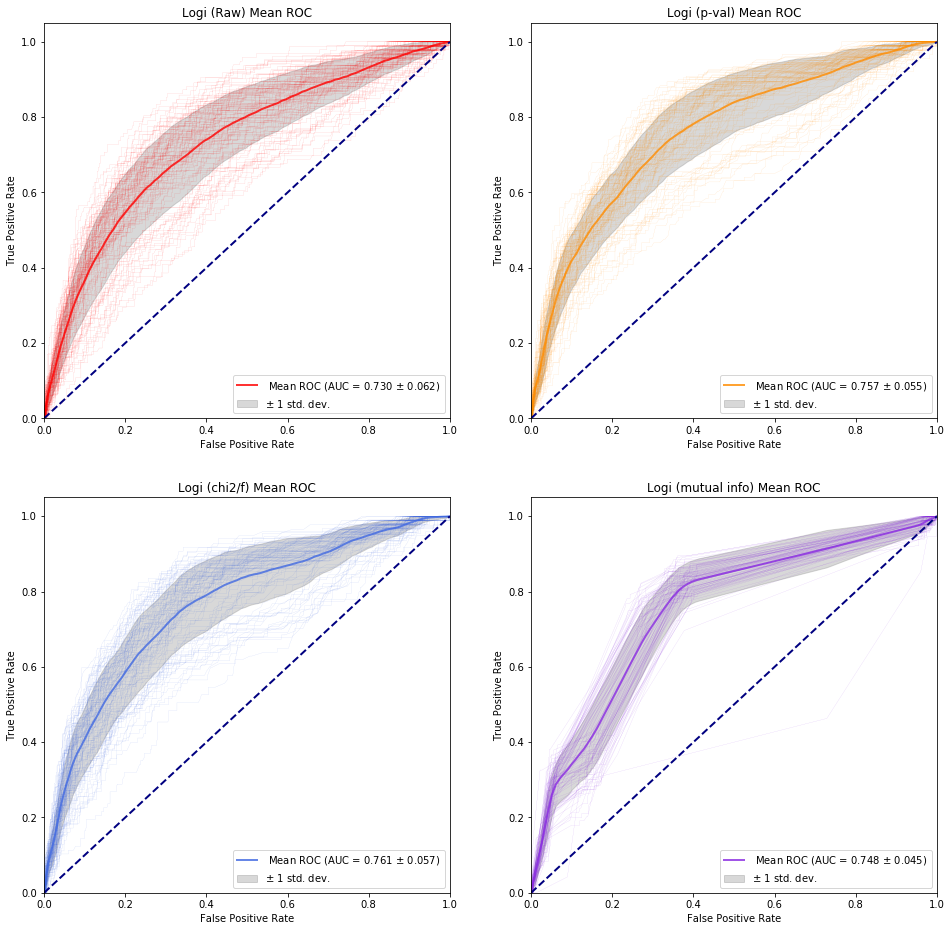

In [46]:
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = fig.add_subplot(2, 2, 1)
c1_mean_fpr, c1_mean_tpr, c1_mean_auc, c1_std_auc = logi_plot_roc(seed_x_train,seed_y_train,colors[0],show_detail=True)
label()
plt.title("Logi (Raw) Mean ROC")

ax = fig.add_subplot(2, 2, 2)
c2_mean_fpr, c2_mean_tpr, c2_mean_auc, c2_std_auc = logi_plot_roc(seed_x_train[p_seed],seed_y_train,colors[1],show_detail=True)
label()
plt.title("Logi (p-val) Mean ROC")

ax = fig.add_subplot(2, 2, 3)
c3_mean_fpr, c3_mean_tpr, c3_mean_auc, c3_std_auc = logi_plot_roc(seed_x_train[chi2_seed],seed_y_train,colors[2],show_detail=True)
label()
plt.title("Logi (chi2/f) Mean ROC")

ax = fig.add_subplot(2, 2, 4)
c4_mean_fpr, c4_mean_tpr, c4_mean_auc, c4_std_auc = logi_plot_roc(seed_x_train[mutual_seed],seed_y_train,colors[3],show_detail=True)
label()
plt.title("Logi (mutual info) Mean ROC")
plt.savefig('seed_4x.png')


plt.show()

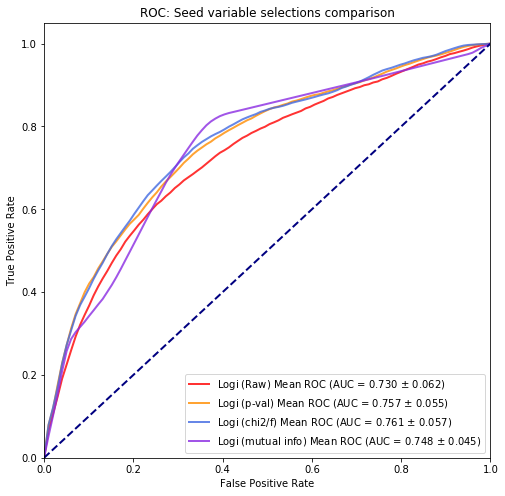

In [47]:
fig = plt.figure(figsize=(8,8))

plt.plot(c1_mean_fpr, c1_mean_tpr, color=colors[0], label="Logi (Raw)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c1_mean_auc, c1_std_auc), lw=2, alpha=0.8)
plt.plot(c2_mean_fpr, c2_mean_tpr, color=colors[1], label="Logi (p-val)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c2_mean_auc, c2_std_auc), lw=2, alpha=0.8)
plt.plot(c3_mean_fpr, c3_mean_tpr, color=colors[2], label="Logi (chi2/f)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c3_mean_auc, c3_std_auc), lw=2, alpha=0.8)
plt.plot(c4_mean_fpr, c4_mean_tpr, color=colors[3], label="Logi (mutual info)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c4_mean_auc, c4_std_auc), lw=2, alpha=0.8)

label()

plt.title("ROC: Seed variable selections comparison")
plt.savefig('seed_all.png')


plt.show()

In [117]:
def test_results(x_train, y_train, x_test, y_test):
    x_train, y_train = downsample(x_train, y_train,rs)
    logi = LogisticRegression(solver='lbfgs',max_iter=400)
    logi.fit(x_train, y_train)
    acc = logi.score(x_test, y_test)
    y_pred = logi.predict(x_test)
    cm = confusion_matrix(y_test, y_pred,labels=[1, 0])
    tpr = cm[0][0]/np.sum(cm[0])
    fpr = cm[1][1]/np.sum(cm[1])
    return(list(np.round([acc,tpr,fpr],3)))

In [118]:
test_results(seed_x_train, seed_y_train, seed_x_test, seed_y_test)

[0.735, 0.679, 0.745]

In [119]:
test_results(seed_x_train[p_seed], seed_y_train, seed_x_test[p_seed], seed_y_test)

[0.748, 0.679, 0.76]

In [120]:
test_results(seed_x_train[chi2_seed], seed_y_train, seed_x_test[chi2_seed], seed_y_test)

[0.764, 0.679, 0.779]

In [121]:
test_results(seed_x_train[mutual_seed], seed_y_train, seed_x_test[mutual_seed], seed_y_test)

[0.743, 0.696, 0.751]

In [127]:
data = [
    ["Seed Raw"] + test_results(seed_x_train, seed_y_train, seed_x_test, seed_y_test),
    ["Seed P-value"] + test_results(seed_x_train[p_seed], seed_y_train, seed_x_test[p_seed], seed_y_test),
    ["Seed Chi2/F"] + test_results(seed_x_train[chi2_seed], seed_y_train, seed_x_test[chi2_seed], seed_y_test),
    ["Seed Mutual"] + test_results(seed_x_train[mutual_seed], seed_y_train, seed_x_test[mutual_seed], seed_y_test)]
df = pd.DataFrame(data, columns = ['Method','Test Accuracy', 'TPR', "FPR"]) 
df

,Method,Test Accuracy,TPR,FPR
0,Seed Raw,0.735,0.679,0.745
1,Seed P-value,0.748,0.679,0.760
2,Seed Chi2/F,0.764,0.679,0.779
3,Seed Mutual,0.743,0.696,0.751


In [135]:
logi = sm.Logit(seed_y_train, seed_x_train[chi2_seed]).fit(method='bfgs',maxiter=1000) # The maxiter is increased to help convergence for seed


Optimization terminated successfully.
         Current function value: 0.443248
         Iterations: 92
         Function evaluations: 100
         Gradient evaluations: 97


/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/xiaoxiangma/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [139]:
print(logi.summary())

                           Logit Regression Results                           
Dep. Variable:            raised_2mil   No. Observations:                 1505
Model:                          Logit   Df Residuals:                     1495
Method:                           MLE   Df Model:                            9
Date:                Tue, 21 Apr 2020   Pseudo R-squ.:                 0.08115
Time:                        17:53:51   Log-Likelihood:                -667.09
converged:                       True   LL-Null:                       -726.00
Covariance Type:            nonrobust   LLR p-value:                 3.708e-21
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
size_numeric             0.0048      0.002      2.786      0.005       0.001       0.008
years                   -0.2970      0.015    -20.006      0.000      -0.326      -0.268
Amsterdam   

In [141]:
seriesA.shape, seed.shape

((529, 20), (1882, 20))

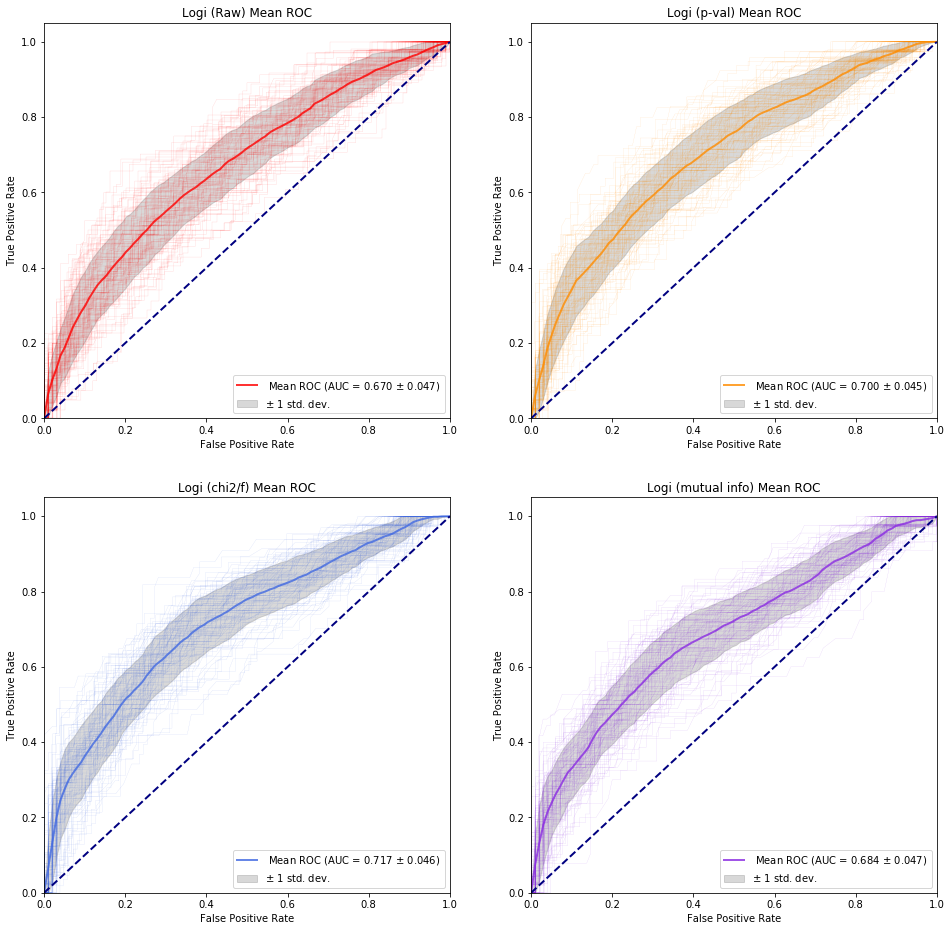

In [53]:
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = fig.add_subplot(2, 2, 1)
c1_mean_fpr, c1_mean_tpr, c1_mean_auc, c1_std_auc = logi_plot_roc(seriesA_x_train,seriesA_y_train,colors[0],show_detail=True)
label()
plt.title("Logi (Raw) Mean ROC")

ax = fig.add_subplot(2, 2, 2)
c2_mean_fpr, c2_mean_tpr, c2_mean_auc, c2_std_auc = logi_plot_roc(seriesA_x_train[p_seriesA],seriesA_y_train,colors[1],show_detail=True)
label()
plt.title("Logi (p-val) Mean ROC")

ax = fig.add_subplot(2, 2, 3)
c3_mean_fpr, c3_mean_tpr, c3_mean_auc, c3_std_auc = logi_plot_roc(seriesA_x_train[chi2_seriesA],seriesA_y_train,colors[2],show_detail=True)
label()
plt.title("Logi (chi2/f) Mean ROC")

ax = fig.add_subplot(2, 2, 4)
c4_mean_fpr, c4_mean_tpr, c4_mean_auc, c4_std_auc = logi_plot_roc(seriesA_x_train[mutual_seriesA],seriesA_y_train,colors[3],show_detail=True)
label()
plt.title("Logi (mutual info) Mean ROC")
plt.savefig('seriesA_4x.png')

plt.show()

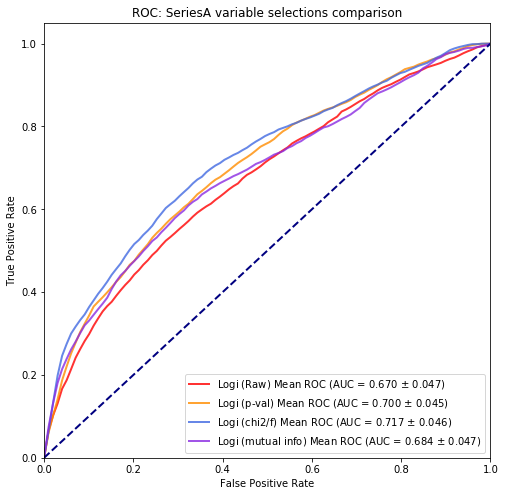

In [54]:
fig = plt.figure(figsize=(8,8))

plt.plot(c1_mean_fpr, c1_mean_tpr, color=colors[0], label="Logi (Raw)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c1_mean_auc, c1_std_auc), lw=2, alpha=0.8)
plt.plot(c2_mean_fpr, c2_mean_tpr, color=colors[1], label="Logi (p-val)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c2_mean_auc, c2_std_auc), lw=2, alpha=0.8)
plt.plot(c3_mean_fpr, c3_mean_tpr, color=colors[2], label="Logi (chi2/f)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c3_mean_auc, c3_std_auc), lw=2, alpha=0.8)
plt.plot(c4_mean_fpr, c4_mean_tpr, color=colors[3], label="Logi (mutual info)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c4_mean_auc, c4_std_auc), lw=2, alpha=0.8)

label()

plt.title("ROC: SeriesA variable selections comparison")
plt.savefig('seriesA_all.png')


plt.show()

In [108]:
test_results(seriesA_x_train, seriesA_y_train, seriesA_x_test, seriesA_y_test)

array([0.566, 0.45 , 0.593])

In [109]:
test_results(seriesA_x_train[p_seriesA], seriesA_y_train, seriesA_x_test[p_seriesA], seriesA_y_test)

array([0.623, 0.3  , 0.698])

In [110]:
test_results(seriesA_x_train[chi2_seriesA], seriesA_y_train, seriesA_x_test[chi2_seriesA], seriesA_y_test)

array([0.623, 0.3  , 0.698])

In [111]:
test_results(seriesA_x_train[mutual_seriesA], seriesA_y_train, seriesA_x_test[mutual_seriesA], seriesA_y_test)

array([0.642, 0.5  , 0.674])

In [128]:
data = [
    ["SeriesA Raw"] + test_results(seriesA_x_train, seriesA_y_train, seriesA_x_test, seriesA_y_test),
    ["SeriesA P-value"] + test_results(seriesA_x_train[p_seriesA], seriesA_y_train, seriesA_x_test[p_seriesA], seriesA_y_test),
    ["SeriesA Chi2/F"] + test_results(seriesA_x_train[chi2_seriesA], seriesA_y_train, seriesA_x_test[chi2_seriesA], seriesA_y_test),
    ["SeriesA Mutual"] + test_results(seriesA_x_train[mutual_seriesA], seriesA_y_train, seriesA_x_test[mutual_seriesA], seriesA_y_test)]
df = pd.DataFrame(data, columns = ['Method','Test Accuracy', 'TPR', "FPR"]) 
df

,Method,Test Accuracy,TPR,FPR
0,SeriesA Raw,0.566,0.45,0.593
1,SeriesA P-value,0.623,0.30,0.698
2,SeriesA Chi2/F,0.623,0.30,0.698
3,SeriesA Mutual,0.642,0.50,0.674
